# Imports

In [4]:
import os
import numpy as np
import tensorflow as tf
import tensorflow.compat.v1 as tf1

import itertools
import keras
import matplotlib.pyplot as plt

from IPython.display import display
from keras.callbacks import TensorBoard
from keras.datasets import cifar10
from keras.utils.image_utils import img_to_array
from keras.utils import load_img, array_to_img
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from numpy.random import seed
from pathlib import Path
from sklearn.metrics import confusion_matrix
from time import strftime

In [30]:
%matplotlib inline

# Set the seeds
seed(888)
tf.random.set_seed(404)

# Constants

In [31]:
LOG_DIR = Path('tensorboard_cifar_logs')
LOG_DIR.mkdir(parents=True, exist_ok=True)

LABEL_NAMES = ['Plane','Car','Bird','Cat','Deer','Dog','Frog','Horse','Ship','Truck']
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
PIXELS = IMAGE_WIDTH * IMAGE_HEIGHT
COLOR_CHANNELS = 3
TOTAL_INPUTS = PIXELS * COLOR_CHANNELS
NR_CLASSES = 10

VALIDATION_SIZE = 10000
SMALL_TRAIN_SIZE = 1000

# Get the Data

In [32]:
(x_train_all, y_train_all), (x_test, y_test) = cifar10.load_data()

In [33]:
type(cifar10)
type(x_train_all)

numpy.ndarray

# Explore the data

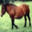

In [34]:
pic = array_to_img(x_train_all[7])
display(pic)

In [35]:
y_train_all.shape

(50000, 1)

In [36]:
y_train_all[7][0]

7

In [37]:
LABEL_NAMES[y_train_all[7][0]]

'Horse'

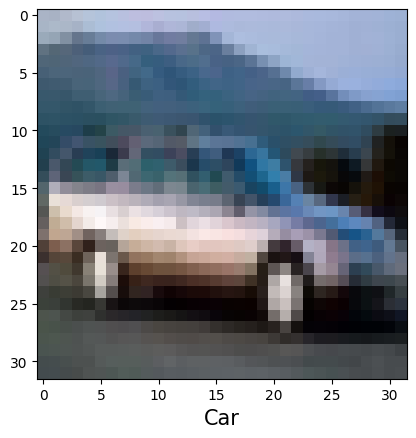

In [38]:
plt.imshow(x_train_all[4])
plt.xlabel(LABEL_NAMES[y_train_all[4][0]], fontsize=15)
plt.show()

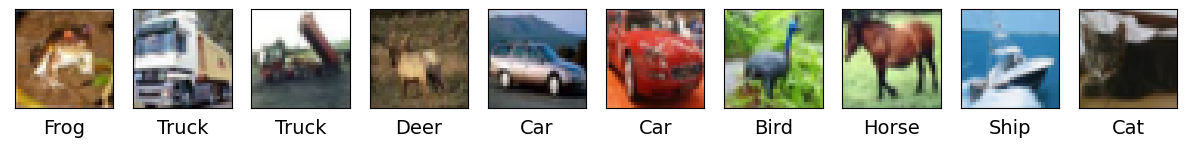

In [39]:
plt.figure(figsize=(15,5))

for i in range(10):
    plt.subplot(1 ,10, i+1)
    plt.yticks([])
    plt.xticks([])
    plt.xlabel(LABEL_NAMES[y_train_all[i][0]], fontsize=14)
    plt.imshow(x_train_all[i])

In [40]:
x_train_all[0].shape

(32, 32, 3)

In [41]:
nr_images, x, y, c = x_train_all.shape
print(f'images = {nr_images} \t| width = {x} \t| height = {y} \t| channels = {c}')

images = 50000 	| width = 32 	| height = 32 	| channels = 3


# Preprocess Data

In [42]:
type(x_train_all[0][0][0][0])

numpy.uint8

In [43]:
x_train_all, x_test = x_train_all /255.0, x_test /255.0

In [44]:
x_train_all[0][0][0][0]

0.23137254901960785

In [45]:
x_train_all = x_train_all.reshape(x_train_all.shape[0], TOTAL_INPUTS)
print(f'Shape of x_test is {x_train_all.shape}')

Shape of x_test is (50000, 3072)


In [46]:
x_test = x_test.reshape(x_test.shape[0], TOTAL_INPUTS)
print(f'Shape of x_test is {x_test.shape}')

Shape of x_test is (10000, 3072)


## Create validation Dataset

In [47]:
x_val = x_train_all[:VALIDATION_SIZE]
y_val = y_train_all[:VALIDATION_SIZE]
x_val.shape

(10000, 3072)

In [48]:
x_train = x_train_all[VALIDATION_SIZE:]
y_train = y_train_all[VALIDATION_SIZE:]
x_train.shape

(40000, 3072)

### Create a small dataset (for illusion)

In [49]:
x_train_xs = x_train[:SMALL_TRAIN_SIZE]
y_train_xs = y_train[:SMALL_TRAIN_SIZE]

## Define the Neural Network Using Keras

In [50]:
model_1 = Sequential([
    Dense(units=128, input_dim=TOTAL_INPUTS, activation='relu', name='m1_hidden1'),
    Dense(units=64, activation='relu', name='m1_hidden2'),
    Dense(16, activation='relu', name='m1_hidden3'),
    Dense(10, activation='softmax', name='m1_output')
])

model_1.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])

In [51]:
model_2 = Sequential()
model_2.add(Dropout(0.2, seed=42, input_shape=(TOTAL_INPUTS,)))
model_2.add(Dense(128, activation='relu', name='m2_hidden1'))
model_2.add(Dense(64, activation='relu', name='m2_hidden2'))
model_2.add(Dense(16, activation='relu', name='m2_hidden3'))
model_2.add(Dense(10, activation='softmax', name='m2_output'))

model_2.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])

In [52]:
model_3 = Sequential()
model_3.add(Dropout(0.2, seed=42, input_shape=(TOTAL_INPUTS,)))
model_3.add(Dense(128, activation='relu', name='m2_hidden1'))
model_3.add(Dropout(0.25, seed=42))
model_3.add(Dense(64, activation='relu', name='m2_hidden2'))
model_3.add(Dense(16, activation='relu', name='m2_hidden3'))
model_3.add(Dense(10, activation='softmax', name='m2_output'))

model_3.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])

In [53]:
type(model_1)

keras.engine.sequential.Sequential

In [54]:
model_1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 m1_hidden1 (Dense)          (None, 128)               393344    
                                                                 
 m1_hidden2 (Dense)          (None, 64)                8256      
                                                                 
 m1_hidden3 (Dense)          (None, 16)                1040      
                                                                 
 m1_output (Dense)           (None, 10)                170       
                                                                 
Total params: 402,810
Trainable params: 402,810
Non-trainable params: 0
_________________________________________________________________


## Tensorboard (Visualizing Learning)

In [55]:
def get_tensorboard(model_name: Sequential) -> TensorBoard:
    folder_name = f'model1_{strftime("%H%M")}'
    dir_paths = Path.joinpath(LOG_DIR, folder_name)
    dir_paths.mkdir(parents=True, exist_ok=True)

    return TensorBoard(log_dir=dir_paths)

## Fit the Model

In [56]:
samples_per_batch = 1000

In [57]:
nr_epochs = 100
model_1.fit(x_train, 
            y_train, 
            batch_size=samples_per_batch, 
            epochs=nr_epochs,
            callbacks=[get_tensorboard('Model 1 XL')],
            verbose=0,
            validation_data=(x_val, y_val))
nr_epochs = 150
model_2.fit(x_train, 
            y_train, 
            batch_size=samples_per_batch, 
            epochs=nr_epochs,
            callbacks=[get_tensorboard('Model 2 XL')],
            verbose=0,
            validation_data=(x_val, y_val))

model_3.fit(x_train, 
            y_train, 
            batch_size=samples_per_batch, 
            epochs=nr_epochs,
            callbacks=[get_tensorboard('Model 3 XL')],
            verbose=0,
            validation_data=(x_val, y_val))

TypeError: start(): incompatible function arguments. The following argument types are supported:
    1. (self: tensorflow.python.profiler.internal._pywrap_profiler.ProfilerSession, arg0: str, arg1: dict) -> None

Invoked with: <tensorflow.python.profiler.internal._pywrap_profiler.ProfilerSession object at 0x000001CF2BF614F0>, WindowsPath('tensorboard_cifar_logs/model1_1215'), {}

## Predictions on Individual Images

In [ ]:
x_val[0].shape

In [ ]:
test = np.expand_dims(x_val[0], axis=0)
test.shape

In [ ]:
np.set_printoptions(precision=3)

In [ ]:
model_2.predict(test)

In [ ]:
model_2.predict(x_val).shape

In [ ]:
np.argmax(model_2.predict(test), axis=-1) # this replaced the model_2.predict_classes(test)

In [ ]:
y_val[0]

In [ ]:
for n in range(10):
    test_img = np.expand_dims(x_val[n], axis=0)
    predicted_val = np.argmax(model_2.predict(test_img), axis=-1)[0]
    print(f'Actual value: {y_val[n][0]} vs predicted: {predicted_val}')

## Evaluation

In [ ]:
model_2.metrics_names

In [ ]:
test_loss, test_accuracy = model_2.evaluate(x_test, y_test)

## Confusion Matrix

In [ ]:
predictions = np.argmax(model_2.predict(x_test), axis=-1)
conf_matrix = confusion_matrix(y_true=y_test, y_pred=predictions)

In [ ]:
nr_rows = conf_matrix.shape[0]
nr_cols = conf_matrix.shape[1]

In [ ]:
conf_matrix.max()

In [ ]:
conf_matrix.min()

In [ ]:
plt.figure(figsize=(7,7), dpi=150)
plt.imshow(conf_matrix, cmap=plt.cm.Greens)

plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')

tick_marks = np.arange(NR_CLASSES)
plt.yticks(tick_marks, LABEL_NAMES)
plt.xticks(tick_marks, LABEL_NAMES)

plt.colorbar()

for i,j in itertools.product(range(nr_rows), range(nr_cols)):
    plt.text(j, i, conf_matrix[i,j], horizontalalignment='center', color='white' if conf_matrix[i,j] > conf_matrix.max()/2 else 'black')

plt.show()

In [ ]:
# True Positives
np.diag(conf_matrix)

In [ ]:
recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
recall

In [ ]:
precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
precision

In [ ]:
avg_recall = np.mean(recall)
print(f'Model 2 recall score is {avg_recall:.2%}')

In [ ]:
avg_precision = np.mean(precision)
print(f'Model 2 recall score is {avg_precision:.2%}')

In [ ]:
f1_score = 2 * ((avg_precision * avg_recall) / (avg_precision + avg_recall))
print(f'Model 2 f score is {f1_score:.2%}')